<a href="https://colab.research.google.com/github/Sushmitha-Katti/EVA-4/blob/master/Session10/FinalS10Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Install Albumentation and Apex Package**

In [1]:
!pip install --no-cache-dir git+https://github.com/albu/albumentations > /dev/null && echo "Albumentation library is successfully installed!"
!pip install --no-cache-dir git+https://github.com/NVIDIA/apex > /dev/null && echo "Apex library is successfully installed!" #Required fro LR finder for mixed precissions

  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-_upc2x54
Albumentation library is successfully installed!
  Running command git clone -q https://github.com/NVIDIA/apex /tmp/pip-req-build-7_wheqyo
  Running command git submodule update --init --recursive -q
Apex library is successfully installed!


## **Mount Drive and Unzip data**

In [4]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
%reload_ext autoreload
%autoreload 2

Mounted at /content/gdrive


In [5]:
import sys
folder = '/content/gdrive/My Drive/Colab Notebooks/eva5/Session10/api'
sys.path.append(folder)
folder = "/content/gdrive/My Drive/Colab Notebooks/eva5/Session10/api/Models"
sys.path.append(folder)

## **Import required modules**

In [6]:
%matplotlib inline
import torch
import train_test_loader
import show_images
from ResnetModel import ResNet18 
import train_test
import evaluate
from Albumentationtransform import AlbumentationTransforms
from GradCam import GradCAM,visualize_cam
from LR_Finder import LRFinder


## **Abumentation Transforms**

In [7]:
import albumentations as A

channel_means = (0.5, 0.5, 0.5)
channel_stdevs = (0.5, 0.5, 0.5)
train_transform = AlbumentationTransforms([
                                       A.Rotate((-30.0, 30.0)),
                                       A.HorizontalFlip(),
                                       A.RGBShift(r_shift_limit=20, g_shift_limit=20, b_shift_limit=20, p=0.5),
                                       A.Normalize(mean=channel_means, std=channel_stdevs),
                                       A.Cutout(num_holes=2, max_h_size=9,max_w_size = 9,p=0.7) 
                                       ])
test_transform = AlbumentationTransforms([A.Normalize(mean=channel_means, std=channel_stdevs)])


## **Load Train Test Data**

In [8]:
classes, trainloader, testloader = train_test_loader.load(train_transform,test_transform)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## **Some training data**

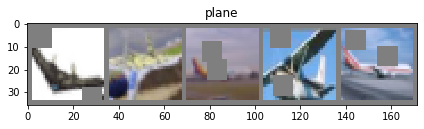

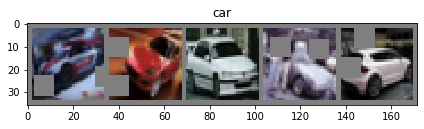

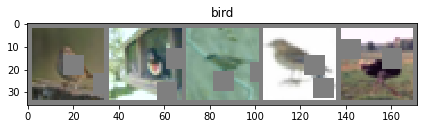

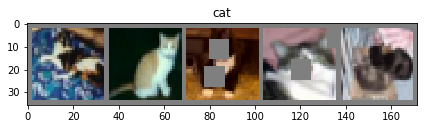

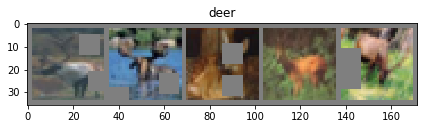

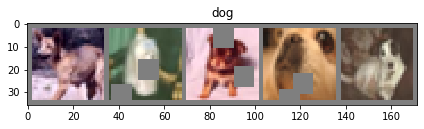

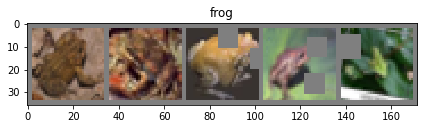

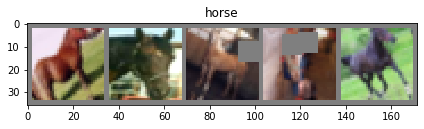

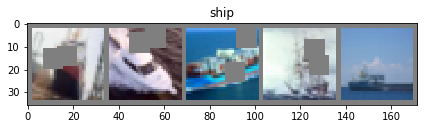

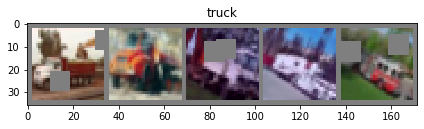

In [9]:
show_images.show_train_data(trainloader, classes)

## **Print Model Summary**

In [10]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = ResNet18(dropout=0.0).to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

## **LR Finder - Finds the best possible LR**

In [11]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimiser = optim.SGD(model.parameters(), lr=0.00001,momentum=0.9 ,weight_decay = 0.0001)
lr_finder = LRFinder(model, optimiser, criterion, device="cuda")
lr_finder.range_test(trainloader, val_loader=testloader, end_lr=1, num_iter=600 ,step_mode="exp")


Learning rate search finished. See the graph with {finder_name}.plot()


## **Plot Lr**

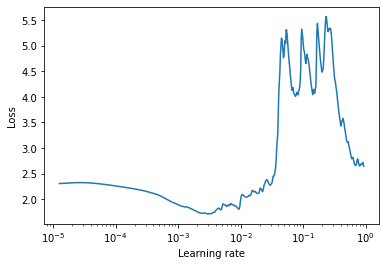

In [12]:
lr_finder.plot()

## **Extract the best LR**

In [13]:
Best_lr = lr_finder.history['lr'][lr_finder.history['loss'].index(lr_finder.best_loss)]

In [14]:
lr_finder.reset()

## **Initialise Loss funtion, Optimizer, Schedular**

In [15]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=Best_lr,momentum=0.9 ,weight_decay = 0.0001)
scheduler = ReduceLROnPlateau(optimizer, patience = 3,min_lr=1e-4)

## **Train the Model for 50 Epochs**

In [17]:
test_loss = []
test_acc = []
EPOCHS = 50
best_acc = 0
for epoch in range(EPOCHS):
     print("EPOCH:", epoch+1,'LR:',optimizer.param_groups[0]['lr'])
     train_loss, train_acc = train_test.train(model, device, trainloader, optimizer, criterion, epoch)
     test_loss , test_acc = train_test.test(model, device, criterion, testloader)
     scheduler.step(test_loss[-1])
     if(test_acc[-1]>best_acc):
       print("accuracy increased, Saving model....")
       best_acc = test_acc[-1]
       torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': test_loss[-1],
            }, "/content/gdrive/My Drive/Colab Notebooks/eva5/Session10/api/bestmodel.pt")
 

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 1 LR: 0.0029853826189179594


Loss=1.0641758441925049 Batch_id=390 Accuracy=59.77: 100%|██████████| 391/391 [01:07<00:00,  5.81it/s]



Test set: Average loss: 0.0076, Accuracy: 6625/10000 (66.25%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 2 LR: 0.0029853826189179594


Loss=0.8422344326972961 Batch_id=390 Accuracy=67.40: 100%|██████████| 391/391 [01:06<00:00,  5.89it/s]



Test set: Average loss: 0.0062, Accuracy: 7295/10000 (72.95%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 3 LR: 0.0029853826189179594


Loss=0.6101847887039185 Batch_id=390 Accuracy=71.77: 100%|██████████| 391/391 [01:06<00:00,  5.92it/s]



Test set: Average loss: 0.0057, Accuracy: 7511/10000 (75.11%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 4 LR: 0.0029853826189179594


Loss=0.6910216212272644 Batch_id=390 Accuracy=74.70: 100%|██████████| 391/391 [01:06<00:00,  5.91it/s]



Test set: Average loss: 0.0055, Accuracy: 7607/10000 (76.07%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 5 LR: 0.0029853826189179594


Loss=0.5136551856994629 Batch_id=390 Accuracy=77.25: 100%|██████████| 391/391 [01:05<00:00,  5.93it/s]



Test set: Average loss: 0.0052, Accuracy: 7766/10000 (77.66%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 6 LR: 0.0029853826189179594


Loss=0.8885194659233093 Batch_id=390 Accuracy=78.47: 100%|██████████| 391/391 [01:05<00:00,  5.94it/s]



Test set: Average loss: 0.0041, Accuracy: 8237/10000 (82.37%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 7 LR: 0.0029853826189179594


Loss=0.5552396774291992 Batch_id=390 Accuracy=80.31: 100%|██████████| 391/391 [01:06<00:00,  5.90it/s]



Test set: Average loss: 0.0040, Accuracy: 8283/10000 (82.83%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 8 LR: 0.0029853826189179594


Loss=0.6298564076423645 Batch_id=390 Accuracy=81.44: 100%|██████████| 391/391 [01:06<00:00,  5.91it/s]



Test set: Average loss: 0.0038, Accuracy: 8381/10000 (83.81%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 9 LR: 0.0029853826189179594


Loss=0.49111565947532654 Batch_id=390 Accuracy=82.87: 100%|██████████| 391/391 [01:06<00:00,  5.88it/s]



Test set: Average loss: 0.0037, Accuracy: 8387/10000 (83.87%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 10 LR: 0.0029853826189179594


Loss=0.3876644968986511 Batch_id=390 Accuracy=83.49: 100%|██████████| 391/391 [01:05<00:00,  5.93it/s]



Test set: Average loss: 0.0036, Accuracy: 8414/10000 (84.14%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 11 LR: 0.0029853826189179594


Loss=0.4407082200050354 Batch_id=390 Accuracy=84.45: 100%|██████████| 391/391 [01:06<00:00,  5.91it/s]



Test set: Average loss: 0.0037, Accuracy: 8425/10000 (84.25%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 12 LR: 0.0029853826189179594


Loss=0.4082866311073303 Batch_id=390 Accuracy=85.38: 100%|██████████| 391/391 [01:06<00:00,  5.89it/s]



Test set: Average loss: 0.0034, Accuracy: 8572/10000 (85.72%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 13 LR: 0.0029853826189179594


Loss=0.34760189056396484 Batch_id=390 Accuracy=85.88: 100%|██████████| 391/391 [01:06<00:00,  5.89it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 8537/10000 (85.37%)

EPOCH: 14 LR: 0.0029853826189179594


Loss=0.45622968673706055 Batch_id=390 Accuracy=86.50: 100%|██████████| 391/391 [01:06<00:00,  5.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 8567/10000 (85.67%)

EPOCH: 15 LR: 0.0029853826189179594


Loss=0.2402651309967041 Batch_id=390 Accuracy=87.25: 100%|██████████| 391/391 [01:06<00:00,  5.89it/s]



Test set: Average loss: 0.0035, Accuracy: 8585/10000 (85.85%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 16 LR: 0.0029853826189179594


Loss=0.45024070143699646 Batch_id=390 Accuracy=87.86: 100%|██████████| 391/391 [01:06<00:00,  5.90it/s]



Test set: Average loss: 0.0032, Accuracy: 8694/10000 (86.94%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 17 LR: 0.0029853826189179594


Loss=0.3390048146247864 Batch_id=390 Accuracy=88.27: 100%|██████████| 391/391 [01:06<00:00,  5.89it/s]



Test set: Average loss: 0.0032, Accuracy: 8712/10000 (87.12%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 18 LR: 0.0029853826189179594


Loss=0.3595098853111267 Batch_id=390 Accuracy=88.81: 100%|██████████| 391/391 [01:06<00:00,  5.89it/s]



Test set: Average loss: 0.0030, Accuracy: 8756/10000 (87.56%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 19 LR: 0.0029853826189179594


Loss=0.5124433040618896 Batch_id=390 Accuracy=89.33: 100%|██████████| 391/391 [01:06<00:00,  5.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 8601/10000 (86.01%)

EPOCH: 20 LR: 0.0029853826189179594


Loss=0.2893863916397095 Batch_id=390 Accuracy=89.64: 100%|██████████| 391/391 [01:06<00:00,  5.89it/s]



Test set: Average loss: 0.0029, Accuracy: 8795/10000 (87.95%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 21 LR: 0.0029853826189179594


Loss=0.45582953095436096 Batch_id=390 Accuracy=90.04: 100%|██████████| 391/391 [01:06<00:00,  5.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Accuracy: 8745/10000 (87.45%)

EPOCH: 22 LR: 0.0029853826189179594


Loss=0.26120641827583313 Batch_id=390 Accuracy=90.48: 100%|██████████| 391/391 [01:06<00:00,  5.89it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 8642/10000 (86.42%)

EPOCH: 23 LR: 0.0029853826189179594


Loss=0.16233041882514954 Batch_id=390 Accuracy=90.88: 100%|██████████| 391/391 [01:06<00:00,  5.91it/s]



Test set: Average loss: 0.0029, Accuracy: 8812/10000 (88.12%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 24 LR: 0.0029853826189179594


Loss=0.20370133221149445 Batch_id=390 Accuracy=91.05: 100%|██████████| 391/391 [01:06<00:00,  5.91it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Accuracy: 8783/10000 (87.83%)

EPOCH: 25 LR: 0.00029853826189179595


Loss=0.1581457108259201 Batch_id=390 Accuracy=93.49: 100%|██████████| 391/391 [01:06<00:00,  5.90it/s]



Test set: Average loss: 0.0024, Accuracy: 9026/10000 (90.26%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 26 LR: 0.00029853826189179595


Loss=0.11504396051168442 Batch_id=390 Accuracy=94.29: 100%|██████████| 391/391 [01:06<00:00,  5.91it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9012/10000 (90.12%)

EPOCH: 27 LR: 0.00029853826189179595


Loss=0.1528913676738739 Batch_id=390 Accuracy=94.55: 100%|██████████| 391/391 [01:06<00:00,  5.88it/s]



Test set: Average loss: 0.0023, Accuracy: 9062/10000 (90.62%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 28 LR: 0.00029853826189179595


Loss=0.170628160238266 Batch_id=390 Accuracy=94.60: 100%|██████████| 391/391 [01:06<00:00,  5.91it/s]



Test set: Average loss: 0.0023, Accuracy: 9078/10000 (90.78%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 29 LR: 0.00029853826189179595


Loss=0.18608896434307098 Batch_id=390 Accuracy=94.84: 100%|██████████| 391/391 [01:06<00:00,  5.91it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9053/10000 (90.53%)

EPOCH: 30 LR: 0.00029853826189179595


Loss=0.20221269130706787 Batch_id=390 Accuracy=95.03: 100%|██████████| 391/391 [01:06<00:00,  5.88it/s]



Test set: Average loss: 0.0023, Accuracy: 9093/10000 (90.93%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 31 LR: 0.00029853826189179595


Loss=0.15881213545799255 Batch_id=390 Accuracy=95.06: 100%|██████████| 391/391 [01:06<00:00,  5.89it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9056/10000 (90.56%)

EPOCH: 32 LR: 0.00029853826189179595


Loss=0.1492438018321991 Batch_id=390 Accuracy=95.11: 100%|██████████| 391/391 [01:06<00:00,  5.88it/s]



Test set: Average loss: 0.0023, Accuracy: 9098/10000 (90.98%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 33 LR: 0.00029853826189179595


Loss=0.2229735553264618 Batch_id=390 Accuracy=95.21: 100%|██████████| 391/391 [01:06<00:00,  5.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9088/10000 (90.88%)

EPOCH: 34 LR: 0.00029853826189179595


Loss=0.055455077439546585 Batch_id=390 Accuracy=95.32: 100%|██████████| 391/391 [01:06<00:00,  5.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9086/10000 (90.86%)

EPOCH: 35 LR: 0.0001


Loss=0.0949617326259613 Batch_id=390 Accuracy=95.54: 100%|██████████| 391/391 [01:06<00:00,  5.91it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9092/10000 (90.92%)

EPOCH: 36 LR: 0.0001


Loss=0.1066664308309555 Batch_id=390 Accuracy=95.58: 100%|██████████| 391/391 [01:05<00:00,  5.93it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9097/10000 (90.97%)

EPOCH: 37 LR: 0.0001


Loss=0.09254436194896698 Batch_id=390 Accuracy=95.64: 100%|██████████| 391/391 [01:06<00:00,  5.91it/s]



Test set: Average loss: 0.0022, Accuracy: 9110/10000 (91.10%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 38 LR: 0.0001


Loss=0.08362536877393723 Batch_id=390 Accuracy=95.53: 100%|██████████| 391/391 [01:06<00:00,  5.89it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9105/10000 (91.05%)

EPOCH: 39 LR: 0.0001


Loss=0.1671508252620697 Batch_id=390 Accuracy=95.63: 100%|██████████| 391/391 [01:06<00:00,  5.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9092/10000 (90.92%)

EPOCH: 40 LR: 0.0001


Loss=0.11917118728160858 Batch_id=390 Accuracy=95.64: 100%|██████████| 391/391 [01:06<00:00,  5.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9110/10000 (91.10%)

EPOCH: 41 LR: 0.0001


Loss=0.15642720460891724 Batch_id=390 Accuracy=95.72: 100%|██████████| 391/391 [01:06<00:00,  5.86it/s]



Test set: Average loss: 0.0022, Accuracy: 9121/10000 (91.21%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 42 LR: 0.0001


Loss=0.17512589693069458 Batch_id=390 Accuracy=95.83: 100%|██████████| 391/391 [01:06<00:00,  5.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9094/10000 (90.94%)

EPOCH: 43 LR: 0.0001


Loss=0.1396121084690094 Batch_id=390 Accuracy=95.70: 100%|██████████| 391/391 [01:06<00:00,  5.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9104/10000 (91.04%)

EPOCH: 44 LR: 0.0001


Loss=0.09499593079090118 Batch_id=390 Accuracy=95.78: 100%|██████████| 391/391 [01:06<00:00,  5.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9111/10000 (91.11%)

EPOCH: 45 LR: 0.0001


Loss=0.09156827628612518 Batch_id=390 Accuracy=95.91: 100%|██████████| 391/391 [01:06<00:00,  5.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9110/10000 (91.10%)

EPOCH: 46 LR: 0.0001


Loss=0.10250747203826904 Batch_id=390 Accuracy=95.86: 100%|██████████| 391/391 [01:06<00:00,  5.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9104/10000 (91.04%)

EPOCH: 47 LR: 0.0001


Loss=0.14405398070812225 Batch_id=390 Accuracy=95.91: 100%|██████████| 391/391 [01:06<00:00,  5.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9116/10000 (91.16%)

EPOCH: 48 LR: 0.0001


Loss=0.11068089306354523 Batch_id=390 Accuracy=95.86: 100%|██████████| 391/391 [01:06<00:00,  5.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9116/10000 (91.16%)

EPOCH: 49 LR: 0.0001


Loss=0.15151920914649963 Batch_id=390 Accuracy=95.79: 100%|██████████| 391/391 [01:06<00:00,  5.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9108/10000 (91.08%)

EPOCH: 50 LR: 0.0001


Loss=0.2831956744194031 Batch_id=390 Accuracy=95.76: 100%|██████████| 391/391 [01:06<00:00,  5.87it/s]



Test set: Average loss: 0.0023, Accuracy: 9127/10000 (91.27%)

accuracy increased, Saving model....


## **Load the Best Accuracy Model**

In [18]:

model = ResNet18(dropout=0.0).to(device)
optimizer = optim.SGD(model.parameters(), lr=Best_lr,momentum=0.9 ,weight_decay = 0.0005)
checkpoint = torch.load("/content/gdrive/My Drive/Colab Notebooks/eva5/Session10/api/bestmodel.pt")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.eval()
print("Loaded the best model")

Loaded the best model


## **Evaluate the class wise accuracy**

In [19]:
evaluate.evaluate_classwise_accuracy(model, device, classes, testloader)

Accuracy of plane : 92 %
Accuracy of   car : 96 %
Accuracy of  bird : 89 %
Accuracy of   cat : 79 %
Accuracy of  deer : 91 %
Accuracy of   dog : 85 %
Accuracy of  frog : 94 %
Accuracy of horse : 92 %
Accuracy of  ship : 95 %
Accuracy of truck : 95 %


## **Plot accurary change in test and train**

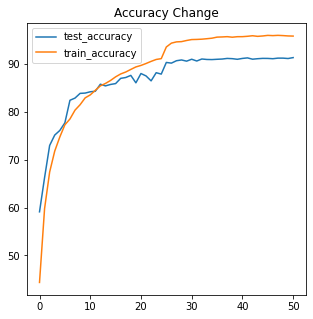

In [27]:
curves = [(test_acc,"test_accuracy"),(train_acc,"train_accuracy")]
evaluate.plot_curve(curves =curves ,title = "Accuracy Change",Figsize = (5,5))



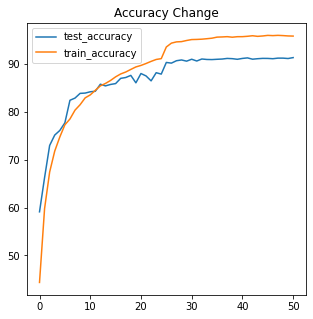

In [29]:
save=evaluate.plot_curve(curves =curves ,title = "Accuracy Change",Figsize = (5,5))


## **Plot Loss Change in Test**
(Couldn't plot both the train and test loss together because both has different scale. So visualisation will not be proper)

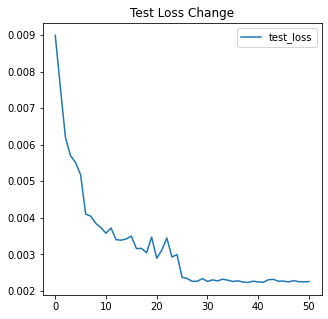

In [21]:
curves = [(test_loss,"test_loss")]
evaluate.plot_curve(curves =curves ,title = "Test Loss Change",Figsize = (5,5))

## **Plot Loss Change in train**

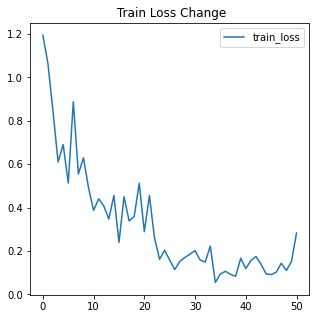

In [22]:
curves = [(train_loss,"train_loss")]
evaluate.plot_curve(curves =curves ,title = " Train Loss Change",Figsize = (5,5))

## **Extract 25 misclassified_images**

In [23]:
miscalssified_images = evaluate.show_misclassified_images(model, device, testloader, classes)


## **GradCam View of misclassified images(for all 4 layers)**

In [24]:

from GradCam import GradCamView
layers = [model.layer1,model.layer2,model.layer3,model.layer4]
miscalssified_images = evaluate.show_misclassified_images(model, device, testloader, classes)
GradCamView(miscalssified_images,model,classes,layers)



  

Output hidden; open in https://colab.research.google.com to view.